<a href="https://colab.research.google.com/github/andreareds/Lab01/blob/main/BoW%2C_Pipeline_and_Hyperperametrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words, Pipeline and Hyperparametrization

In this notebook, we will see how to use a Pipeline in sklearn, how to look for optimal hyperparameters with a grid search method. To do so, we are gonna apply it to a classification problem of text documents that will be represented via the Bag-of-words model.



Let's import useful Python packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Dataset

Stanford University researchers have taken 50,000 movie reviews from [IMDB](https://www.imdb.com/) labelled them as either positive or negative and [made them available](http://ai.stanford.edu/~amaas/data/sentiment/). We created a dataset with 2,500 positive reviews and the 2,500 negative reviews

Let's read the dataset available on: https://github.com/andvise/DataAnalyticsDatasets/blob/8e8f6475f49d2a587e4f5c76cdf0b011b22c6ac1/dataset_5000_reviews.csv 

In [ ]:
df = pd.read_csv("https://github.com/andvise/DataAnalyticsDatasets/blob/8e8f6475f49d2a587e4f5c76cdf0b011b22c6ac1/dataset_5000_reviews.csv?raw=true")

In [ ]:
df.head()

,Review,Sentiment
0,Shiri Appleby is the cutest little embodiment ...,Negative
1,"Normally, I have much better things to do with...",Negative
2,this movie is not good.the first one almost su...,Negative
3,"As a biographical film, ""The Lady With Red Hai...",Positive
4,I do not fail to recognize Haneke's above-aver...,Negative


In [ ]:
df.tail()

,Review,Sentiment
4995,Los Angeles TV news reporter Jennifer (the bea...,Positive
4996,"This film is absolutely awful, but nevertheles...",Negative
4997,...however I am not one of them. Caro Diario a...,Negative
4998,This film had a great cast going for it: Chris...,Negative
4999,If you look at Corey Large's information here ...,Negative


In [ ]:
df['Sentiment'].value_counts()

Negative    2500
Positive    2500
Name: Sentiment, dtype: int64

## Preprocessing

Let's encode the labels as 0 and 1 using the *LabelEncoder*.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['Sentiment'])
df['Sentiment'] = label_encoder.transform(df['Sentiment'])

In [ ]:
df.head()

,Review,Sentiment
0,Shiri Appleby is the cutest little embodiment ...,0
1,"Normally, I have much better things to do with...",0
2,this movie is not good.the first one almost su...,0
3,"As a biographical film, ""The Lady With Red Hai...",1
4,I do not fail to recognize Haneke's above-aver...,0


Split the dataset into training set (80%) and test set (20%).

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df['Review'], df['Sentiment'], train_size=0.8, random_state=2)

In [ ]:
print("Train_X:", train_X.shape)
print("Train_y:", train_y.shape)
print("Test_X:", test_X.shape)
print("Test_y:", test_y.shape)

Train_X: (4000,)
Train_y: (4000,)
Test_X: (1000,)
Test_y: (1000,)


# Classification Task

## Count Vectorizer (BoW) + KNN Classifier

Create a Pipeline in sklearn with a Count Vectorizer and KNN Classifier with arbitrary parameter and the compute the validation error using *cross_val_score* (default=5-fold cross validation).

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
classifier = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', max_features=100)),
    ("predictor", KNeighborsClassifier(n_neighbors=5))])

np.mean(cross_val_score(classifier, train_X, train_y, scoring="accuracy"))

0.58

In [ ]:
X = classifier['vectorizer'].fit_transform(train_X)
X.shape

(4000, 100)

Find the best hyperparameter using a GridSearchCV on:

**CountVectorizer:**
*   Stop words: None, English
*   ngram range: (1,1),(1,2)

**KNN Classifier:**
*   Number of neighbors: 3, 5, 7, 9, 10, 15, 20, 25, 30

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html






In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Let's try some grid search
classifierKNN = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("predictor", KNeighborsClassifier())])

# Create a dictionary of hyperparameters for the pipeline with the KNN classifier
knn_param_grid = {"vectorizer__stop_words": [None, "english"],
                  "vectorizer__ngram_range": [(1, 1), (1, 2)],
                  "predictor__n_neighbors": [3,5,7,9,10, 15, 20, 25, 30]}

# Create the grid search object which will find the best hyperparameter values based on validation error
knn_gs = GridSearchCV(classifierKNN, knn_param_grid, scoring="accuracy")

# Run the GridSearchCV
knn_gs.fit(train_X, train_y)

# Print the best parameters and the score
knn_gs.best_params_, knn_gs.best_score_

({'predictor__n_neighbors': 30,
  'vectorizer__ngram_range': (1, 1),
  'vectorizer__stop_words': None},
 0.65475)

Retrain the model using the best hyperparameters found with GridSearchCV and compute the accuracy.


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
classifierKNN.set_params(**knn_gs.best_params_) 
classifierKNN.fit(train_X, train_y)
accuracy_score(test_y, classifierKNN.predict(test_X))

0.659

In [ ]:
classifierKNN = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,1), stop_words=None)),
    ("predictor", KNeighborsClassifier(n_neighbors=30))])
classifierKNN.fit(train_X, train_y)
accuracy_score(test_y, classifierKNN.predict(test_X))

0.659

## Count Vectorizer (BoW) + Decision Tree

Create a Pipeline in sklearn with a Count Vectorizer and Decision Tree Classifier with arbitrary parameter and the compute the validation error.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html



In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# We can just create a preprocessor with a CountVectorizer in a pipeline with a decision tree.
classifierDT = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', max_features=100)),
    ("predictor", DecisionTreeClassifier())])

# Get the validation error
np.mean(cross_val_score(classifierDT, train_X, train_y, scoring="accuracy"))

0.61625

Find the best hyperparameter using a GridSearchCV on:

**CountVectorizer:**
*   Stop words: None, English
*   ngram range: (1,1), (1,2)

**Decision Tree:**
*   criterion: gini, entropy

In [ ]:
# Let's try some grid search
classifierDT = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("predictor", DecisionTreeClassifier())])

# Create a dictionary of hyperparameters for the pipeline with a decision tree
dt_param_grid = {"vectorizer__stop_words": [None, "english"],
                 "vectorizer__ngram_range": [(1, 1), (1, 2)],
                 "predictor__criterion": ["gini", "entropy"]}

# Create the grid search object which will find the best hyperparameter values based on validation error
dt_gs = GridSearchCV(classifierDT, dt_param_grid, scoring="accuracy")

# Run the GridSearchCV
dt_gs.fit(train_X, train_y)

# Print the best parameters and the score
dt_gs.best_params_, dt_gs.best_score_

({'predictor__criterion': 'gini',
  'vectorizer__ngram_range': (1, 1),
  'vectorizer__stop_words': 'english'},
 0.7064999999999999)

Retrain the model using the best hyperparameters found with GridSearchCV and compute the accuracy.


In [ ]:
classifierDT.set_params(**dt_gs.best_params_) 
classifierDT.fit(train_X, train_y)
accuracy_score(test_y, classifierDT.predict(test_X))

0.715

In [ ]:
classifierDT = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,1), stop_words='english')),
    ("predictor", DecisionTreeClassifier(criterion='gini'))])
classifierDT.fit(train_X, train_y)
accuracy_score(test_y, classifierDT.predict(test_X))

0.712

Plot the decision tree.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html


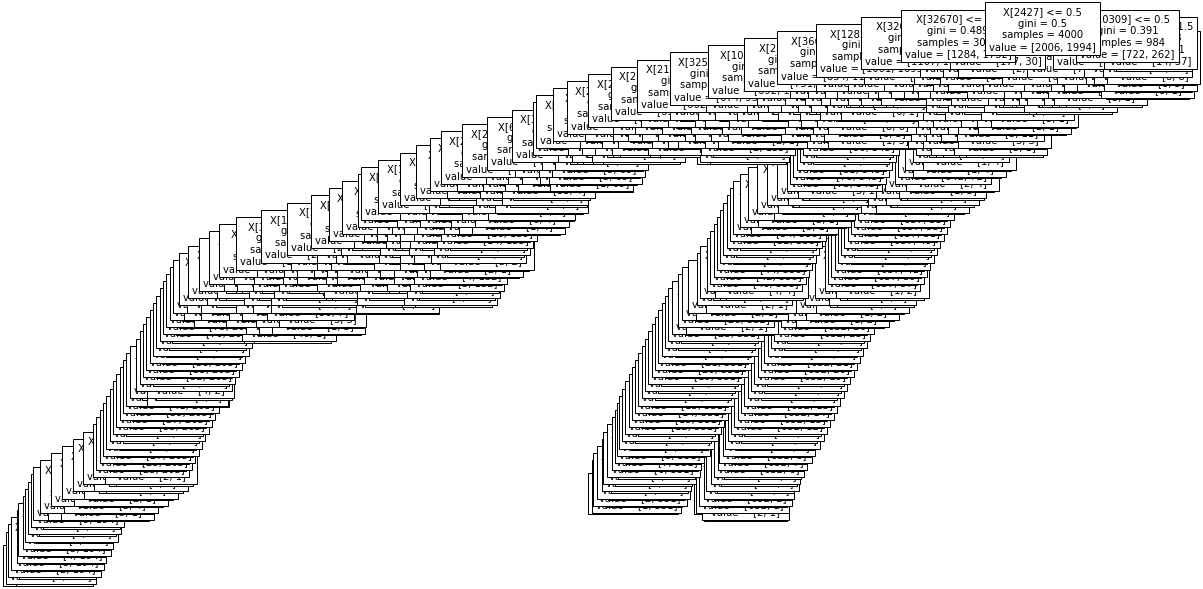

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(classifierDT['predictor'], fontsize=10)
plt.show()

The decision tree is too big. We can reduce the dimension by setting the depth of tree.

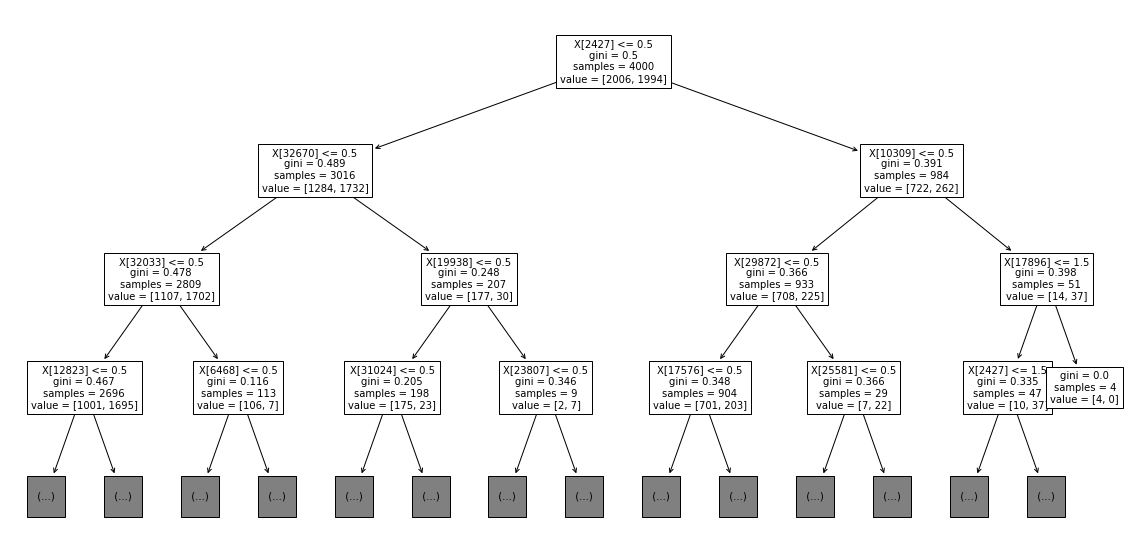

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(classifierDT['predictor'],  max_depth=3, fontsize=10)
plt.show()

Let's check which are the first words used in the branches in the decision tree.

In [ ]:
classifierDT['vectorizer'].get_feature_names_out()[2427]

'bad'

In [ ]:
classifierDT['vectorizer'].get_feature_names_out()[32670]

'worst'

In [ ]:
classifierDT['vectorizer'].get_feature_names_out()[10309]

'excellent'

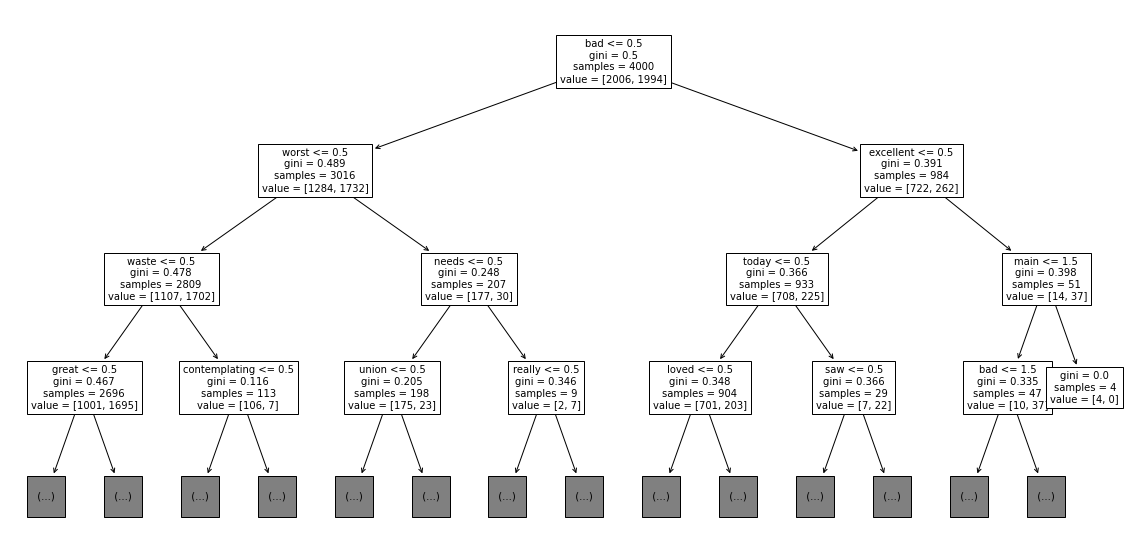

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(classifierDT['predictor'],  max_depth=3, fontsize=10, feature_names=classifierDT['vectorizer'].get_feature_names_out())
plt.show()

### Can we do better?

In [ ]:
vect = CountVectorizer()
X = vect.fit_transform(train_X)
X

<4000x33358 sparse matrix of type '<class 'numpy.int64'>'
	with 554336 stored elements in Compressed Sparse Row format>

In [ ]:
print("Zero values:", 100 - 554336/(4000*33358))

Zero values: 99.99584555428983


In [ ]:
from sklearn.decomposition import TruncatedSVD

dr = TruncatedSVD(n_components=200)
X = dr.fit_transform(X)
X

array([[ 1.24988447e+01, -3.93589826e+00, -4.20627624e-01, ...,
        -6.27264539e-02, -1.24990697e-01,  1.85276849e-01],
       [ 3.28613609e+01,  2.92904657e+00, -5.82669027e+00, ...,
        -3.67219517e-01,  8.92888495e-02, -1.30451439e-02],
       [ 2.13679229e+01, -2.96531189e+00,  3.28030967e+00, ...,
        -3.26121709e-01, -2.32037342e-01,  8.11569795e-01],
       ...,
       [ 5.74256920e+01,  9.98469605e-01,  4.16640180e+00, ...,
        -1.16507263e-01, -1.67726265e+00,  2.82135638e+00],
       [ 9.57523992e+00,  1.10638102e+00,  3.13101704e+00, ...,
        -1.47587515e-01,  2.89307738e-01, -3.58243778e-01],
       [ 2.35870485e+01,  1.93636845e+00,  5.35258628e+00, ...,
         5.46205024e-02, -2.43614433e-01, -8.59038787e-02]])

In [ ]:
X.shape

(4000, 200)

# Dimensionality Reduction: SVD

Let's add SVD to our pipelines

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html



In [ ]:
from sklearn.decomposition import TruncatedSVD

### Decision Tree

In [ ]:
# Let's try some grid search
classifierDTSVD = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("svd", TruncatedSVD()),
    ("predictor", DecisionTreeClassifier())])

# Create a dictionary of hyperparameters for the pipeline with a decision tree
dtsvd_param_grid = {"vectorizer__stop_words": [None, "english"],
                    "vectorizer__ngram_range": [(1, 1), (1, 2)],
                    "svd__n_components": [100, 200],
                    "predictor__criterion": ["gini", "entropy"]
                   }

# Create the grid search object which will find the best hyperparameter values based on validation error
dtsvd_gs = GridSearchCV(classifierDTSVD, dtsvd_param_grid, scoring="accuracy")

# Run the GridSearchCV
dtsvd_gs.fit(train_X, train_y)

# Print the best parameters and the score
dtsvd_gs.best_params_, dtsvd_gs.best_score_

({'predictor__criterion': 'entropy',
  'svd__n_components': 200,
  'vectorizer__ngram_range': (1, 2),
  'vectorizer__stop_words': 'english'},
 0.642)

In [ ]:
classifierDTSVD.set_params(**dtsvd_gs.best_params_) 
classifierDTSVD.fit(train_X, train_y)
accuracy_score(test_y, classifierDTSVD.predict(test_X))

0.642

In [ ]:
classifierDTSVD = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ("svd", TruncatedSVD(n_components=200)),
    ("predictor", DecisionTreeClassifier(criterion='entropy'))])

classifierDTSVD.fit(train_X, train_y)
accuracy_score(test_y, classifierDTSVD.predict(test_X))

0.629

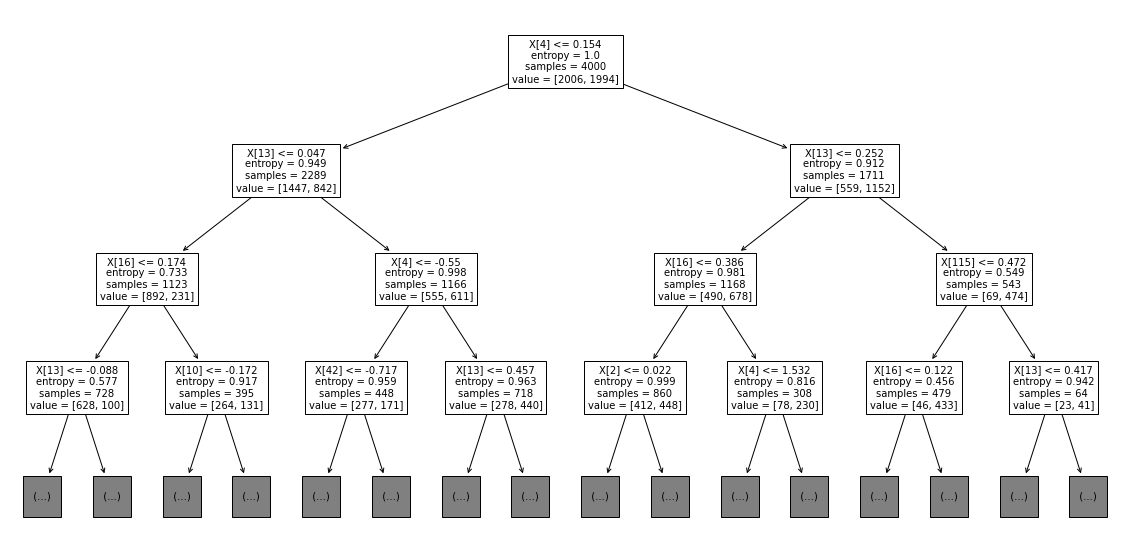

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(classifierDTSVD['predictor'],  max_depth=3, fontsize=10)
plt.show()

### KNN

In [ ]:
# Let's try some grid search
classifierKNNSVD = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("svd", TruncatedSVD()),
    ("predictor", KNeighborsClassifier())])

# Create a dictionary of hyperparameters for the pipeline with the KNN classifier
knnsvd_param_grid = {"vectorizer__stop_words": [None, "english"],
                     "vectorizer__ngram_range": [(1, 1), (1, 2)],
                     "svd__n_components": [100, 200, 300, 400],
                     "predictor__n_neighbors": [3,5,7,9,10, 15, 20, 25, 30]
                    }

# Create the grid search object which will find the best hyperparameter values based on validation error
knnsvd_gs = GridSearchCV(classifierKNNSVD, knnsvd_param_grid, scoring="accuracy")

# Run the GridSearchCV
knnsvd_gs.fit(train_X, train_y)

# Print the best parameters and the score
knnsvd_gs.best_params_, knnsvd_gs.best_score_

({'predictor__n_neighbors': 25,
  'svd__n_components': 100,
  'vectorizer__ngram_range': (1, 1),
  'vectorizer__stop_words': 'english'},
 0.671)

In [ ]:
from sklearn.metrics import accuracy_score

classifierKNNSVD.set_params(**knnsvd_gs.best_params_) 
classifierKNNSVD.fit(train_X, train_y)
accuracy_score(test_y, classifierKNNSVD.predict(test_X))

0.687

In [ ]:
classifierKNNSVD = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,1), stop_words='english')),
    ("svd", TruncatedSVD(n_components=400)),
    ("predictor", KNeighborsClassifier(n_neighbors=15))])

classifierKNNSVD.fit(train_X, train_y)
accuracy_score(test_y, classifierKNNSVD.predict(test_X))

0.658

In [ ]:
print("KNN", accuracy_score(test_y, classifierKNN.predict(test_X)))
print("DT", accuracy_score(test_y, classifierDT.predict(test_X)))

print("KNN + SVD", accuracy_score(test_y, classifierKNNSVD.predict(test_X)))
print("DT + SVD", accuracy_score(test_y, classifierDTSVD.predict(test_X)))

KNN 0.659
DT 0.712
KNN + SVD 0.658
DT + SVD 0.629
